# <center> 👉 class_11_3 » _Feature Matching Corrections_ </center>

## Finding Good Maching  

It refers to the work of discarding useless matching points from the matching results and picking out only the correct matching points.  

매칭 결과에서 쓸모없는 매칭점은 버리고 올바른 매칭점만 골라내는 작업을 말함

- **match()** :  
>- Compare all the descriptors one by one to find the match point.   
>- So you can only pick the top few percent of the smallest and largest distance values to find the right match.
>- Extract the descriptor with the ORB and calculate the match with the BF-Hamming matcher  
>- Sort by distance of the matching results and select only the 20% matching points with a shorter distance   

    >- 모든 디스크립터를 하나하나 비교하여 매칭점을 찾습니다.   
    >- 따라서 가장 작은 거리 값과 큰 거리 값의 상위 몇 퍼센트만 골라서 올바른 매칭점을 찾을 수 있습니다.
    >- ORB로 디스크립터를 추출하고 BF-Hamming 매칭기로 매칭을 계산  
    >- 매칭 결과의 거리(distance)를 기준으로 정렬하고 거리가 짧은 20%의 매칭점만 선택  
    
- __knnMatch():__   
>- Returns k nearest neighbor matching points per descriptor, in order of proximity.  
>- The closest neighbor of k is a good match, 
>- Greater distance is more likely to be a poor match.   
>- If you focus on the closest neighbors with a close distance, you can find a good match.     

    >- 디스크립터당 k개의 최근접 이웃 매칭점을 가까운 순서대로 반환합니다.  
    >- k개의 최근접 이웃 중 거리가 가까운 것은 좋은 매칭점이고, 
    >- 거리가 먼 것은 좋지 않은 매칭점일 가능성이 높습니다.   
    >- 최근접 이웃 중 거리가 가까운 것 위주로 골라내면 좋은 매칭점을 찾아낼 수 있습니다.    

In [1]:
# match (match_good.py)
import cv2, numpy as np

img1 = cv2.imread('./images/practice_img/taekwonv1.jpg')
img2 = cv2.imread('./images/practice_img/figures.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(desc1, desc2)

matches = sorted(matches, key=lambda x:x.distance)
min_dist, max_dist = matches[0].distance, matches[-1].distance
ratio = 0.2          # Set 20% of the minimum distance as the threshold 최소 거리의 20% 지점을 임계점으로 설정
good_thresh = (max_dist - min_dist) * ratio + min_dist
good_matches = [m for m in matches if m.distance < good_thresh]  # Only matching points smaller than the threshold point are classified as good matching points ---⑥
print('matches:%d/%d, min:%.2f, max:%.2f, thresh:%.2f' %(len(good_matches),len(matches), min_dist, max_dist, good_thresh))
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
cv2.imshow('Good Match', res)
cv2.waitKey()
cv2.destroyAllWindows()

matches:18/127, min:24.00, max:78.00, thresh:34.80


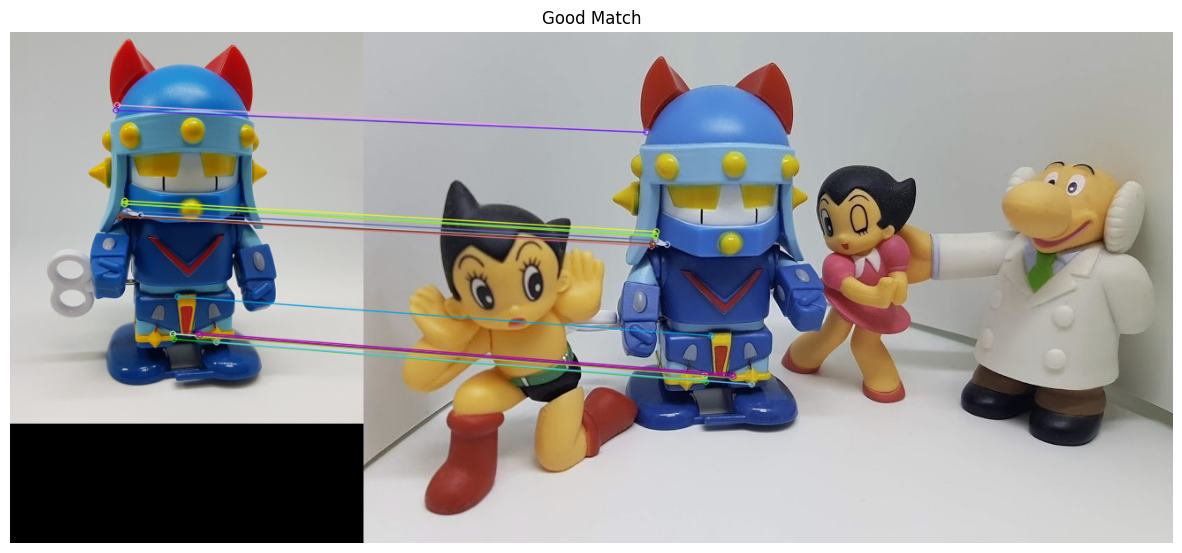

In [2]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=100)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Good Match')

plt.show()

In [3]:
# knnMatch (match_good_knn.py)
import cv2, numpy as np

img1 = cv2.imread('./images/practice_img/taekwonv1.jpg')
img2 = cv2.imread('./images/practice_img/figures.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

detector = cv2.ORB_create() 
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)

matcher = cv2.BFMatcher(cv2.NORM_HAMMING2) # BF-Hamming 
matches = matcher.knnMatch(desc1, desc2, 2) # knnMatch, k=2 
ratio = 0.75           # Extract only those where the first neighbor's street is within 75% of the second neighbor's street.
good_matches = [first for first,second in matches if first.distance < second.distance * ratio]
print('matches:%d/%d' %(len(good_matches),len(matches)))

res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
cv2.imshow('Matching', res)
cv2.waitKey()
cv2.destroyAllWindows()

matches:23/500


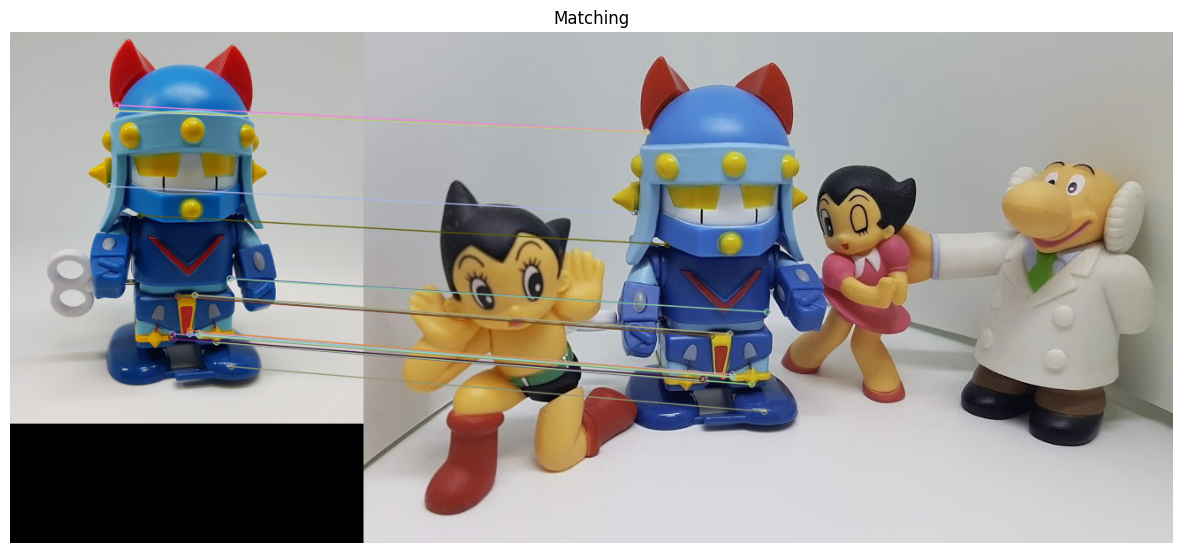

In [4]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=100)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Matching')

plt.show()

## ▶ Homography 

By taking the perspective transformation matrix at the correctly matched coordinates, you can show where the object is being matched.     
- The object you're comparing might have been slightly rotated on the two photos, or it might be a little different in size.   
- For this, if you get the perspective transformation matrix, you will be able to find the location of the object you are looking for well.   
- In addition, you can distinguish between matching points that do not fit into the perspective transformation matrix, so you can remove the bad match points once again.

>- The function to __find the perspective transformation matrix__ with multiple matching points is __cv2.findHomography()__,   
>- The function that __converts the original coordinates to the perspective transformation matrix__ is __cv2.perspectiveTransform()__.  

    올바르게 매칭된 좌표들에 원근 변환 행렬을 구하면 매칭 되는 물체가 어디 있는지 표시할 수 있습니다.   
    비교하려는 물체가 두 사진 상에서 약간 회전했을 수도 있고 크기가 조금 다를 수도 있습니다.   
    이에 대해 원근 변환 행렬을 구하면 찾고자 하는 물체의 위치를 잘 찾을 수 있습니다.   
    더불어 원근 변환 행렬에 들어맞지 않는 매칭점을 구분할 수 있어서 나쁜 매칭점을 한번 더 제거할 수 있습니다.

    여러 매칭점으로 원근 변환 행렬을 구하는 함수는 cv2.findHomography()이고, 
    원래 좌표들을 원근 변환 행렬로 변환하는 함수는 cv2.perspectiveTransform()입니다.

- **mtrx, mask = cv2.findHomography(srcPoints, dstPoints, method, ransacReprojThreshold, mask, maxIters, confidence)**  

>- srcPoints: src Points
>- dstPoints: dst Points
>- method=0(optional): 
>>- 0: Least Squared Error, 
>>- cv2.RANSAC,   
>>- cv2.LMEDS,   
>>- cv2.RHO
>- ransacReprojThreshold=3(optional): Normal distance threshold(RANSAC, RHO)
>- maxIters=2000(optional): Iters
>- confidence=0.995(optional): confidence(0~1)
>- mtrx: result
>- mask: N x 1 (0: abnormal, 1: normal)

- **dst = cv2.perspectiveTransform(src, m, dst)**  

>- src: input coord
>- m: conversion array
>- dst(optional): output coord

The cv2.findHomography() function is similar to the cv2.getPerspectiveTransform() function.   
- However, cv2.getPerspectiveTransform() returns the exact perspective transformation matrix with 4 vertices, but   
- cv2.findHomography() returns a perspective transformation matrix approximated by multiple points.   
- The cv2.perspectiveTransform() function returns a new array of coordinates to transform to perspective.  

    cv2.findHomography() 함수는 cv2.getPerspectiveTransform() 함수와 비슷합니다.   
    - 다만 cv2.getPerspectiveTransform()은 4개의 꼭짓점으로 정확한 원근 변환 행렬을 반환하지만,   
    - cv2.findHomography()는 여러 개의 점으로 근사 계산한 원근 변환 행렬을 반환합니다.   
    - cv2.perspectiveTransform() 함수는 원근 변환할 새로운 좌표 배열을 반환합니다.

The method parameter of the cv2.findHomography() function has a set of 0, cv2. RANSAC, cv2. LMEDS, cv2. You can pass the value of the RHO.   
- This is an algorithm for approximating perspective transformations.   
- The default value of 0 approximates all coordinates by the law of least squares. 
- This is calculated for all coordinates, so if there is an incorrect match, the error may be significant.  

    cv2.findHomography() 함수의 method 파라미터에는 0, cv2.RANSAC, cv2.LMEDS, cv2.RHO의 값을 전달할 수 있습니다.   
    - 이는 원근 변환의 근사 계산을 위한 알고리즘입니다.   
    - default 값인 0은 모든 좌표를 최소 제곱 법으로 근사 계산합니다. 
    - 이는 모든 좌표에 대해 계산되므로 틀린 매칭점이 있다면 오차가 클 수 있습니다.

__If you pass cv2.RANSAC to the method parameter,__
- Uses RANSAC (Random Sample Consensus) algorithm.
- This is a method of finding satisfaction by selecting only random coordinates without using all coordinates.
- Only those with the highest satisfaction obtained in this way are selected and approximate calculations are made.
- Selected points are classified as normal values, and other points are classified as outliers and judged as noise.
- At this time, you can set the ransacReprojThreshold value as the threshold to distinguish outliers.
- The conversion values are the result conversion matrix (mtrx) and the normal value determination result (mask).
- In the mask, normal values are displayed as 1 and outliers are displayed as 0 at the same index as the input coordinates.
- This can be used to distinguish between correct and bad matching points.
- Even with feature matching, there are many incorrect matching points.
- However, if you use cv2.RANSAC, it returns a mask that distinguishes normal values from outliers, so you can once again distinguish between correct and bad matching points.  

    method 파라미터에 cv2.RANSAC를 전달하면 
    - RANSAC(Random Sample Consensus) 알고리즘을 사용합니다.   
    - 이는 모든 좌표를 사용하지 않고 임의의 좌표만 선정해서 만족도를 구하는 방식인데,   
    - 이렇게 구한 만족도가 큰 것만 선정하여 근사 계산합니다.   
    - 선정된 점들은 정상치로 분류하고 그 외의 점들은 이상치로 분류해서 노이즈로 판단합니다.   
    - 이때 이상치를 구분하는 임계 값으로 ransacReprojThreshold 값을 정하면 됩니다.   
    - 변환 값은 결과 변환 행렬(mtrx)과 정상치 판별 결과(mask)입니다.   
    - mask에는 입력 좌표와 동일한 인덱스에 정상치는 1, 이상치는 0으로 표시됩니다.   
    - 이는 올바른 매칭점과 나쁜 매칭점을 구분하는데 활용할 수 있습니다.   
    - 특징 매칭을 하더라도 올바르지 않은 매칭점들이 많이 있습니다.   
    - 하지만 cv2.RANSAC을 활용한다면 정상치와 이상치를 구분해주는 mask를 반환하므로 올바른 매칭점과 나쁜 매칭점을 한번 더 구분할 수 있습니다.  
    
__method parameter in cv2. LMEDS,__   
- Utilize the Least Median of Squares (LMedS) algorithm to use the least median of squares.   
- This algorithm is easy to use because it does not require any additional parameters,   
- It only works normally if the normal value is above 50%, so you need to be careful.  

    method 파라미터에 cv2.LMEDS를 전달하면   
    - LMedS(Least Median of Squares) 알고리즘을 활용하여 제곱의 최소 중간값을 사용합니다.   
    - 이 알고리즘은 추가적인 파라미터를 요구하지 않아 사용하기에는 편하지만,   
    - 정상치가 50% 이상인 경우에만 정상적으로 작동하니 주의할 필요가 있습니다.  
    
__cv2. RHO uses the Progressive Sample Consensus (PROSAC) algorithm, which is an enhancement of RANSAC.__   
- This algorithm is faster when there are a lot of outliers.  

    cv2.RHO는 RANSAC을 개선한 PROSAC(Progressive Sample Consensus) 알고리즘을 사용합니다.   
    - 이 알고리즘은 이상치가 많은 경우에 더 빠릅니다.


## ▶ Matching Homography  

Homography refers to the perspective transform between two planes.  

    호모그래피(Homography)는 두 평면 사이의 투시 변환(Perspective transform)을 의미합니다.

<img src='./images/practice_img/homography_transformation_example3.jpg' width=800 height=600>

### ● How the homography transformation can be useful?   
- Perspective removal / correction (see the previous second example)  
<img src='./images/practice_img/homograph3.png' width=600 height=400>  

- Panorama stitching (see the previous second and third example)  
<img src='./images/practice_img/homography_panorama_stitching.jpg' width=600 height=400>

In this way, __the ability to transform a photo taken at an angle into a photograph taken from the front is called homography.__

    이처럼 비스듬하게 찍은 사진을 정면에서 찍은 사진처럼 변환할 수 있다는 것을 호모그래피라고 합니다.

### ■ cv2.findHomgraphy  

**cv2.findHomography(srcPoints, dstPoints, method=None, ransacReprojThreshold=None, mask=None, maxIters=None, confidence=None)**

>- srcPoints: src Key Points. numpy.ndarray. shape=(N, 1, 2). dtype=numpy.float32.  
>- dstPoints: tgt Key Points. numpy.ndarray. shape=(N, 1, 2). dtype=numpy.float32.  
>- method:  0(default), LMEDS, RANSAC, RHO,  If there are outliers, RANSAC, RHO method is recommended 이상치가 있을 경우 RANSAC, RHO 방법 권장.  
>- ransacReprojThreshold: RANSAC Threshold (default=3)  
>- maxIters: RANSAC max iterations (default=2000)  
>- retval: return val numpy.ndarray. shape=(3, 3). dtype=numpy.float32.  
>- mask: out mask (RANSAC, RHO : Inlier point=1 array. numpy.ndarray. shape=(N, 1), dtype=uint8)  

- The srcPoints and dstPoints values must be converted to (N, 1, 2).  
- It is recommended to use RANSAC as an algorithm that works well when there are a lot of outliers.
- The outputs are retval and mask(N,1)  

>- When 80 points are entered, a matrix is created only for those that are judged to be non-outliers and those that are judged to be outliers.  
>- If that matrix element is filled with 1, it means it was used as an enliar.  
>- Similarly, if the matrix element is 0, it means an outlier. 

> srcPoints, dstPoints 값은 (N, 1, 2)로 변환하여 입력해야 합니다.  
> RANSAC는 이상점이 많을 때 잘 작동하는 알고리즘으로 RANSAC를 사용하는 것이 좋습니다.
> 출력값은 2개 입니다. -> retval, mask(N,1)  
>
>80개의 점을 입력했을 때 이상점이 아닌 것으로 판단되는 것과 이상점으로 판단되는 것들에 대해서만 행렬을 만들어 줍니다.  
>- 그 행렬 요소가 1로 채워져있다면 인라이어로 사용되었다는 의미입니다.  
>- 마찬가지로 행렬 요소가 0이라면 아웃라이어를 의미합니다.  

### ● RANSAC (Random Sample Consensus)   

RANSAC can find the straight line that is most likely to be the main axis even when there are many outliers.
Select two random points and draw a straight line.
By putting some offset on this straight line, we figure out how many points are within the range.
This method is repeated and the equation of the straight line is calculated using the two points that contain the most points within the offset range.

Here, perspective conversion is performed with 4 points out of 80, and verification is performed with the remaining 76 points.
If perspective conversion is performed with outlier points included, the matching results within the offset range will be reduced.
Then we discard those four dots.  

    RANSAC는 이상점이 많은 경우에도 가장 주축이 될 것 같은 직선을 찾아낼 수 있습니다.  
    임의의 두 점을 선별해 직선을 그립니다.  
    이 직선에 어느 정도 offset을 두어 범위 안에 있는 점들이 몇 개 있는지 파악합니다.  
    이 방법을 반복하고, offset 범위 안에 가장 많은 점을 포함한 두 점을 이용해서 직선의 방정식을 계산하는 방법입니다.  

    여기서는 80개 중 4개의 점으로 투시변환을 해보고 나머지 76개 점들로 검증을 하게 됩니다.  
    이상점이 포함된 상태로 투시변환하게 된다면 offset 범위안에 들어오는 매칭 결과가 적게됩니다.  
    그러면 그 4개의 점을 버립니다.

# of kp1: 2462
# of kp2: 2324
# of matches: 2462
# of good_matches: 80


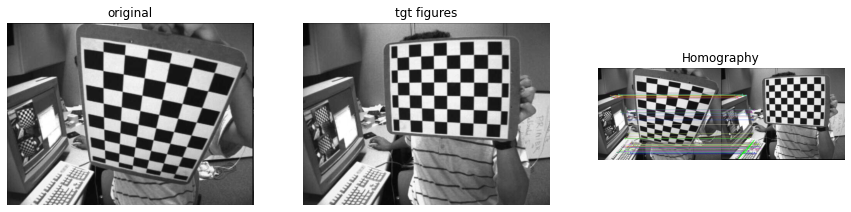

In [10]:
# Ex Homgraphy 

src1 = cv2.imread('./images/practice_img/homograph-src.png', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread('./images/practice_img/homograph-tgt.png', cv2.IMREAD_GRAYSCALE)

if src1 is None or src2 is None:
    print('Image load failed!')
    sys.exit()

feature = cv2.KAZE_create()   # L2 norm
#feature = cv2.AKAZE_create()
#feature = cv2.ORB_create()

kp1, desc1 = feature.detectAndCompute(src1, None)
kp2, desc2 = feature.detectAndCompute(src2, None)
matcher = cv2.BFMatcher_create()
matches = matcher.match(desc1, desc2)
matches = sorted(matches, key=lambda x: x.distance)
good_matches = matches[:80]

print('# of kp1:', len(kp1))
print('# of kp2:', len(kp2))
print('# of matches:', len(matches))
print('# of good_matches:', len(good_matches))

# Take queryIdx and trainIdx from a DMatch object and convert them to size and type 
# DMatch 객체에서 queryIdx와 trainIdx를 받아와서 크기와 타입 변환
pts1 = np.array([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2).astype(np.float32)
pts2 = np.array([kp1[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2).astype(np.float32)
                
H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC) # (N,1,2)

dst = cv2.drawMatches(src1, kp1, src2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
(h, w) = src1.shape[:2]

corners1 = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2).astype(np.float32) # 4 points
corners2 = cv2.perspectiveTransform(corners1, H) # Convert perspective to homography H matrices on input images 입력 영상에 호모그래피 H 행렬로 투시 변환
corners2 = corners2 + np.float32([w, 0])  # Shift by the width of the input image 입력영상의 넓이 만큼 쉬프트

cv2.polylines(dst, [np.int32(corners2)], True, (0, 255, 0), 2, cv2.LINE_AA)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()

from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15,10))
axs[0].imshow(src1,'gray'), axs[0].axis('off'), axs[0].set_title('original')
axs[1].imshow(src2,'gray'), axs[1].axis('off'), axs[1].set_title('tgt figures')
axs[2].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)), axs[2].axis('off'), axs[2].set_title('Homography')

plt.show()

When you're looking for a simple image, template matching is a good fit.
Homographic is useful for matching complex things like photographs.

단순한 이미지를 찾을 때는 템플릿 매칭이 적절합니다.  
호모그래피는 사진처럼 복잡한 것을 매칭할때 유용합니다.

In [11]:
# Finding an Area with Transform Matching Point Perspective (match_homography.py)

import cv2, numpy as np

img1 = cv2.imread('./images/practice_img/taekwonv1.jpg')
img2 = cv2.imread('./images/practice_img/figures.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING2)
matches = matcher.knnMatch(desc1, desc2, 2)

ratio = 0.75
good_matches = [first for first,second in matches if first.distance < second.distance * ratio]
print('good matches:%d/%d' %(len(good_matches),len(matches)))

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ])
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ])
mtrx, mask = cv2.findHomography(src_pts, dst_pts)
h,w, = img1.shape[:2]
pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
dst = cv2.perspectiveTransform(pts,mtrx)
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
cv2.imshow('Matching Homography', res)
cv2.waitKey()
cv2.destroyAllWindows()

good matches:21/500


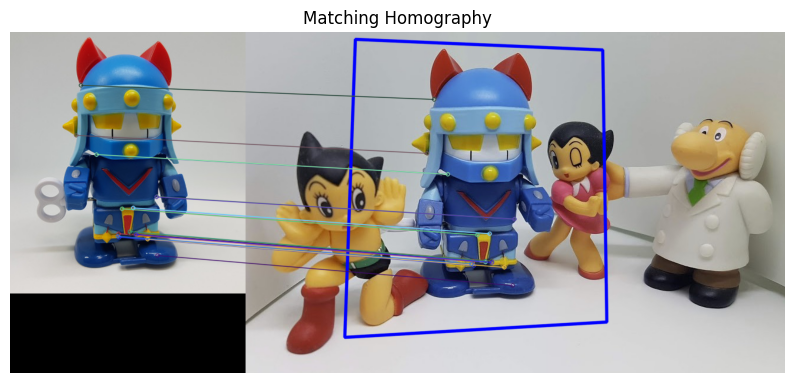

In [13]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=100)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Matching Homography')

plt.show()

- print('good matches:%d/%d' %(len(good_matches),len(matches)))  

이 부분까지는 '올바른 매칭점 찾기'에서 활용한 코드와 동일합니다.  
원근 변환 행렬을 구하는 코드는 아래 부분입니다.

* 좋은 매칭점의 queryIdx로 원본 영상의 좌표 구하기: **src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ])**

* 좋은 매칭점의 trainIdx로 대상 영상의 좌표 구하기: **dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ])**

* 원근 변환 행렬 구하기: **mtrx, mask = cv2.findHomography(src_pts, dst_pts)** 

우선 good_matches는 knnMatch() 함수의 반환 결과입니다.

이전 포스팅에서 살펴본 바와 같이 match(), knnMatch(), radiusMatch() 함수의 반환 결과는 DMatch 객체 리스트입니다.

- **DMatch:** 매칭 결과를 표현하는 객체 
>- queryIdx: queryDescriptors의 인덱스
>- trainIdx: trainDescriptors의 인덱스
>- imgIdx: trainDescriptor의 이미지 인덱스
>- distance: 유사도 거리

따라서 good_matches 배열에서 하나의 원소 m에 대한 m.queryIdx 값은 입력 이미지의 디스크립터(queryDescriptors)에 해당하는 인덱스입니다.  
그리하여 kp1[m.queryIdx].pt는 ORB로 추출한 모든 특징점들 중 m.queryIdx에 해당하는 특징점 좌표들만 선택한다는 뜻입니다.   
이것이 바로 올바른 매칭점입니다. 입력 이미지에 대한 올바른 매칭점 src_pts와 대상 이미지에 대한 올바른 매칭점 dst_pts를 구했습니다.   
올바른 매칭점인 src_pts, dst_pts를 활용하여 cv2.findHomography() 함수로 원근 변환 행렬을 구할 수 있습니다. 

아래의 코드를 활용하여 원근 변환한 도형을 대상 이미지에 표시했습니다.

    h,w, = img1.shape[:2]  
    pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])  
- 원본 영상 좌표를 원근 변환: **dst = cv2.perspectiveTransform(pts,mtrx)**
- 변환 좌표 영역을 대상 영상에 그리기: **img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)**

먼저, 원본 이미지의 크기에 대한 사각형 좌표를 구합니다.   
그다음 이 사각형 좌표에 대해 원근 변환 행렬(mtrx)을 합니다.   
이렇게 구한 원근 변환된 좌표를 대상 이미지에 표시했습니다. 이렇게 해서 찾는 물체가 어디 있는지 나타낼 수 있습니다.   
사실 본 예제에는 잘못된 매칭점이 포함되어 있지 않았습니다.   
하지만 대부분의 경우 올바른 매칭점을 골라내도 그 속에는 잘못된 매칭점이 섞여 있습니다.   
이 경우 결과 값 mask를 활용하여 정상치와 이상치를 구별해주어 잘못된 매칭점을 추가로 제거해주어야 합니다. 

다음은 RANSAC 원근 변환 근사 계산으로 잘못된 매칭을 추가로 제거하는 코드입니다.

In [18]:
# RANSAC Perspective Transformation Approximate Calculation Eliminates Bad Matching (match_homography_accuracy.py)

import cv2, numpy as np

img1 = cv2.imread('./images/practice_img/taekwonv1.jpg')
img2 = cv2.imread('./images/practice_img/figures2.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB, BF-Hamming 로 knnMatch  ---①
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(desc1, desc2)

matches = sorted(matches, key=lambda x:x.distance)
res1 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ])
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])
mtrx, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
h,w = img1.shape[:2]
pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
dst = cv2.perspectiveTransform(pts,mtrx)
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

matchesMask = mask.ravel().tolist()
res2 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, matchesMask = matchesMask,
                        flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
accuracy=float(mask.sum()) / mask.size
print("accuracy: %d/%d(%.2f%%)"% (mask.sum(), mask.size, accuracy))

cv2.imshow('Matching-All', res1)
cv2.imshow('Matching-Inlier ', res2)
cv2.waitKey()
cv2.destroyAllWindows()

accuracy: 25/135(0.19%)


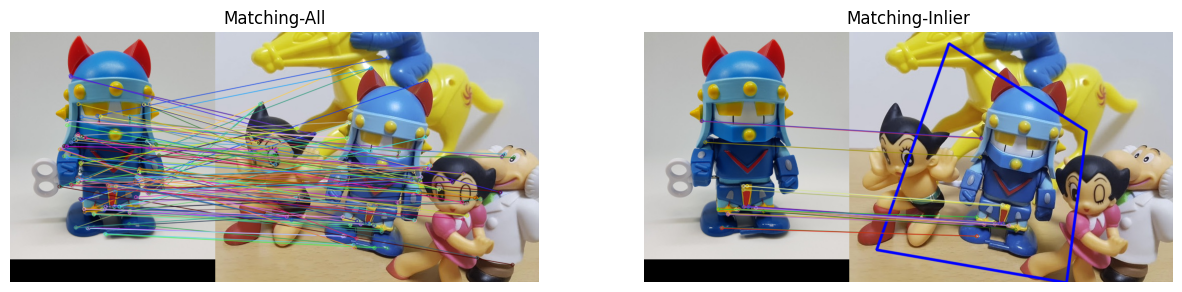

In [21]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(cv2.cvtColor(res1, cv2.COLOR_BGR2RGB)), axs[0].axis('off'), axs[0].set_title('Matching-All')
axs[1].imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB)), axs[1].axis('off'), axs[1].set_title('Matching-Inlier')

plt.show()

In [ ]:
# Homography Examples from Learnopencv

https://github.com/spmallick/learnopencv/tree/master  
    
<img src='./images/practice_img/homography_books.jpg'  width=600 height=400>


In [ ]:
import cv2
import numpy as np

def mouseHandler(event,x,y,flags,param):
    global im_temp, pts_src

    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(im_temp,(x,y),3,(0,255,255),5,cv2.LINE_AA)
        cv2.imshow("Image", im_temp)
        if len(pts_src) < 4:
            pts_src = np.append(pts_src,[(x,y)],axis=0)

im_src = cv2.imread("./images/practice_img/book1.jpg")
height, width = 400, 300               # Destination image
im_dst = np.zeros((height,width,3),dtype=np.uint8)

pts_dst = np.empty((0,2))              # Create a list of points.
pts_dst = np.append(pts_dst, [(0,0)], axis=0)
pts_dst = np.append(pts_dst, [(width-1,0)], axis=0)
pts_dst = np.append(pts_dst, [(width-1,height-1)], axis=0)
pts_dst = np.append(pts_dst, [(0,height-1)], axis=0)

cv2.namedWindow("Image", 1)
im_temp = im_src
pts_src = np.empty((0,2))
cv2.setMouseCallback("Image",mouseHandler)

cv2.imshow("Image", im_temp)
cv2.waitKey(0)

tform, status = cv2.findHomography(pts_src, pts_dst)
im_dst = cv2.warpPerspective(im_src, tform,(width,height))

cv2.imshow("Image", im_dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

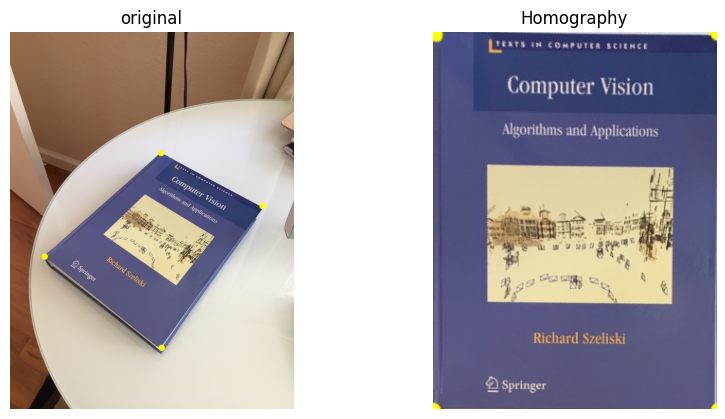

In [5]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10, 5), dpi=100)

plt.subplot(121),plt.imshow(cv2.cvtColor(im_src, cv2.COLOR_BGR2RGB)),plt.title('original'),plt.axis('off')
plt.subplot(122),plt.imshow(cv2.cvtColor(im_dst, cv2.COLOR_BGR2RGB)),plt.title('Homography'),plt.axis('off')
plt.show()

In [1]:
import cv2
import numpy as np

im_src = cv2.imread("./images/practice_img/book2.jpg")  # Read source image.
pts_src = np.array([[141, 131], [480, 159], [493, 630],[64, 601]], dtype=float) # Four corners of the book in source image
im_dst = cv2.imread("./images/practice_img/book1.jpg")  # Read destination image.
pts_dst = np.array([[318, 256],[534, 372],[316, 670],[73, 473]], dtype=float)   # Four corners of the book in destination image.
h, status = cv2.findHomography(pts_src, pts_dst)        # Calculate Homography

im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0])) # Warp source image to destination based on homography

cv2.imshow("Source Image", im_src)
cv2.imshow("Destination Image", im_dst)
cv2.imshow("Warped Source Image", im_out)

cv2.waitKey(0)
cv2.destroyAllWindows()

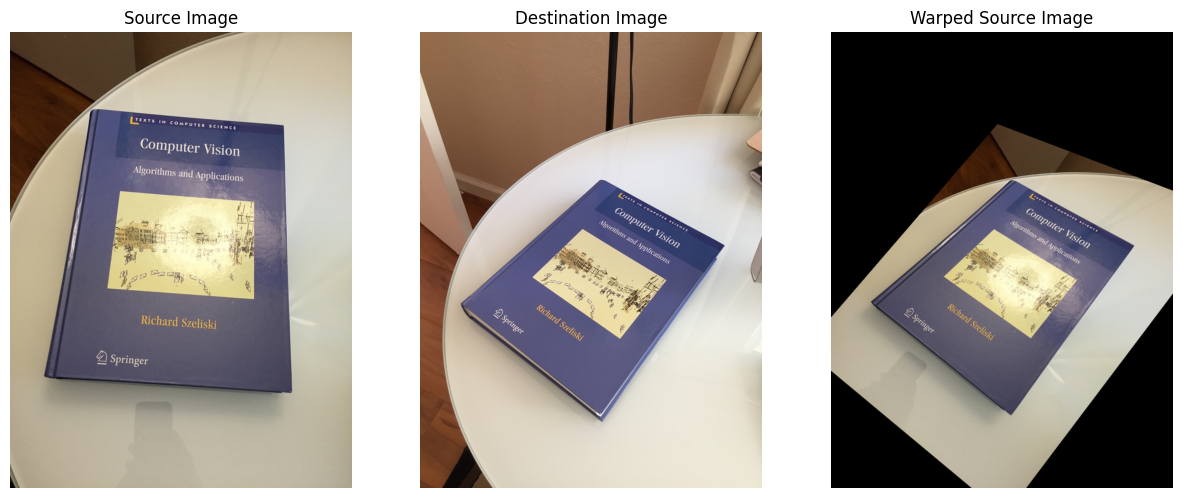

In [4]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=100)

plt.subplot(131),plt.imshow(cv2.cvtColor(im_src, cv2.COLOR_BGR2RGB)),plt.title('Source Image'),plt.axis('off')
plt.subplot(132),plt.imshow(cv2.cvtColor(im_dst, cv2.COLOR_BGR2RGB)),plt.title('Destination Image'),plt.axis('off')
plt.subplot(133),plt.imshow(cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB)),plt.title('Warped Source Image'),plt.axis('off')
plt.show()

### Warp Two Images  

Warp img2 to img1 with homograph H

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img1 = cv2.imread("./images/practice_img/homograph2.jpg")  # Read image 1
img2 = cv2.imread("./images/practice_img/homograph1.jpg")  # Read image 2
img1_g = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2_g = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1_g,None)
kp2, des2 = sift.detectAndCompute(img2_g,None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
good = []
for m in matches:                     
    if (m[0].distance < 0.5*m[1].distance):  # some trivial descriptors will be eliminated by ratio test.
        good.append(m)
matches = np.asarray(good)

if (len(matches[:,0]) >= 4):
    src = np.float32([kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dst = np.float32([kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
else:
    raise AssertionError('Can’t find enough keypoints.')

dst = cv2.warpPerspective(img1,H,((img1.shape[1] + img2.shape[1]), img2.shape[0])) # wraped image
dst[0:img2.shape[0], 0:img2.shape[1]] = img2                                        # stitched image

cv2.imshow('output',dst)

cv2.waitKey(0)
cv2.destroyAllWindows()

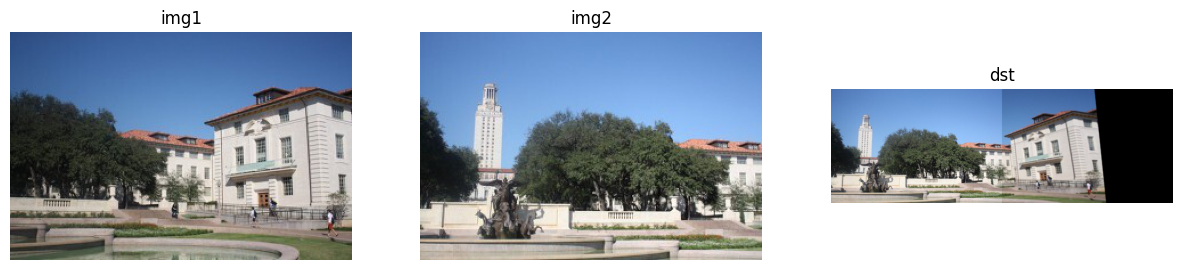

In [8]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=100)

plt.subplot(131),plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)),plt.title('img1'),plt.axis('off')
plt.subplot(132),plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)),plt.title('img2'),plt.axis('off')
plt.subplot(133),plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)),plt.title('dst'),plt.axis('off')
plt.show()

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def mouse_handler(event, x, y, flags, data) :
    
    if event == cv2.EVENT_LBUTTONDOWN :
        cv2.circle(data['im'], (x,y),3, (0,0,255), 5, 16);
        cv2.imshow("Image", data['im']);
        if len(data['points']) < 4 :
            data['points'].append([x,y])
            
def get_four_points(im):
    
    # Set up data to send to mouse handler
    data = {}
    data['im'] = im.copy()
    data['points'] = []
    
    #Set the callback function for any mouse event
    cv2.imshow("Image",im)
    cv2.setMouseCallback("Image", mouse_handler, data)
    cv2.waitKey(0)
    
    # Convert array to np.array
    points = np.vstack(data['points']).astype(float)
    
    return points

# Read in the image.
im_src = cv2.imread("./images/practice_img/book1.jpg")

# Destination image
size = (300,400,3)

im_dst = np.zeros(size, np.uint8)


pts_dst = np.array([[0,0],[size[0] - 1, 0],[size[0] - 1, size[1] -1],[0, size[1] - 1 ]], dtype=float)


# Show image and wait for 4 clicks.
cv2.imshow("Image", im_src)
pts_src = get_four_points(im_src);

# Calculate the homography
h, status = cv2.findHomography(pts_src, pts_dst)

# Warp source image to destination
im_dst = cv2.warpPerspective(im_src, h, size[0:2])

# Show output
cv2.imshow("Image", im_dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
#!/usr/bin/env python

import cv2
import numpy as np
import sys

def mouse_handler(event, x, y, flags, data) :
    if event == cv2.EVENT_LBUTTONDOWN :
        cv2.circle(data['im'], (x,y),3, (0,0,255), 5, 16);
        cv2.imshow("Image", data['im']);
        if len(data['points']) < 4 :
            data['points'].append([x,y])
            
def get_four_points(im):
    data = {}
    data['im'] = im.copy()
    data['points'] = []
    
    cv2.imshow("Image",im)
    cv2.setMouseCallback("Image", mouse_handler, data)
    cv2.waitKey(0)
    
    points = np.vstack(data['points']).astype(float)
    
    return points

im_src = cv2.imread('./images/practice_img/first-image.jpg');
size = im_src.shape
pts_src = np.array([[0,0],[size[1] - 1, 0],[size[1] - 1, size[0] -1],[0, size[0] - 1 ]],dtype=float);

im_dst = cv2.imread('./images/practice_img/times-square.jpg');
im_tgt = im_dst.copy()

print('Click on four corners of a billboard and then press ENTER') # Get four corners of the billboard
pts_dst = get_four_points(im_dst)
h, status = cv2.findHomography(pts_src, pts_dst); # Calculate Homography between source and destination points
im_temp = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0])) # Warp source image
cv2.fillConvexPoly(im_dst, pts_dst.astype(int), 0, 16);  # Black out polygonal area in destination image.
im_dst = im_dst + im_temp; # Add warped source image to destination image.

cv2.imshow("Image", im_dst);
cv2.waitKey(0)
cv2.destroyAllWindows()

Click on four corners of a billboard and then press ENTER


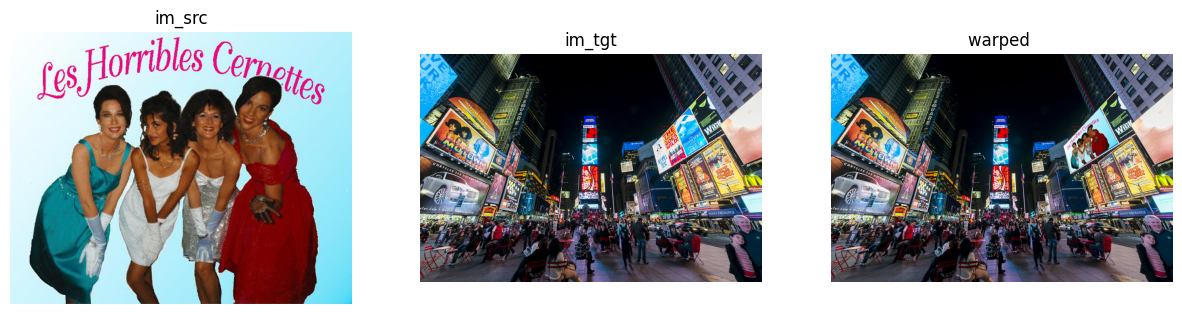

In [8]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=100)

plt.subplot(131),plt.imshow(cv2.cvtColor(im_src, cv2.COLOR_BGR2RGB)),plt.title('im_src'),plt.axis('off')
plt.subplot(132),plt.imshow(cv2.cvtColor(im_tgt, cv2.COLOR_BGR2RGB)),plt.title('im_tgt'),plt.axis('off')
plt.subplot(133),plt.imshow(cv2.cvtColor(im_dst, cv2.COLOR_BGR2RGB)),plt.title('warped '),plt.axis('off')
plt.show()